# giảm số chiều dữ liệu xuống còn 100 chiều (từ 28x28 = 784 chiều ban đầu) với tập dữ liệu 5000 ảnh bất kỳ. 


In [26]:
import os
import numpy as np

data_path = "E:\ML\ANN"
# train path
train_images_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')
# test path
test_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')

In [27]:
def get_mnist_data(images_path, labels_path, num_images, shuffle=False, _is=True, image_size=28):
    """
    This shuffle param is active when .gz is downloaded at:
    - 'http://yann.lecun.com/exdb/mnist/'
    - This function return random num_images in 60000 or 10000
    """
    # read data
    import gzip # to decompress gz (zip) file
    
    # open file training to read training data
    f_images = gzip.open(images_path,'r')
    
    # skip 16 first bytes because these are not data, only header infor
    f_images.read(16)
    
    # general: read num_images data samples if this parameter is set;
    # if not, read all (60000 training or 10000 test)
    real_num = num_images if not shuffle else (60000 if _is else 10000)
    
    # read all data to buf_images (28x28xreal_num)
    buf_images = f_images.read(image_size * image_size * real_num)
    
    # images
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size, image_size,)
    
    # Read labels
    f_labels = gzip.open(labels_path,'r')
    f_labels.read(8)
    labels = np.zeros((real_num)).astype(np.int64)
    
    # rearrange to correspond the images and labels
    for i in range(0, real_num):
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)

    # shuffle to get random images data
    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)
        images = images[rand_id, :]
        labels = labels[rand_id,]
        
    # change images data to type of vector 28x28 dimentional
    images = images.reshape(num_images, image_size * image_size)
    return images, labels

In [28]:
images, labels = get_mnist_data(train_images_path, train_labels_path, 5000, shuffle=True)

print(images.shape, labels.shape)

C:\Users\Admin\AppData\Local\Temp\ipykernel_29236\3109302176.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)


(5000, 784) (5000,)


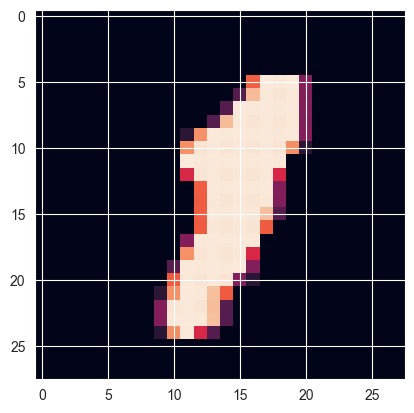

In [29]:
import random
import matplotlib.pyplot as plt


def get_image(image, size):
    return image.reshape(size, size)

index = random.randint(0, 1000)
image = np.asarray(get_image(images[index], 28)).squeeze()
plt.imshow(image)

In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Apply PCA with n_components=100
pca = PCA(n_components=100)
images_reduced = pca.fit_transform(StandardScaler().fit_transform(images))

# The shape of images_reduced will be (5000, 100)
print(images_reduced.shape)

(5000, 100)


2


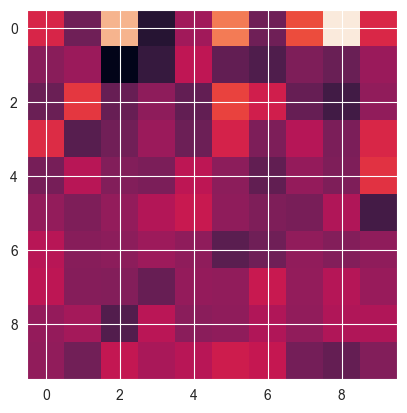

In [31]:
index = random.randint(0, 1000)
print(labels[index])

image = np.asarray(get_image(images_reduced[index], 10)).squeeze()
plt.imshow(image)

# Sử dụng Multinomial Logistic, ANN để phân loại

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_reduced, labels, test_size=0.3, random_state=0)

## Multinomial Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial', max_iter=1000)
model.fit(X_train, y_train)

# Đánh giá mô hình
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f' % accuracy)

Accuracy: 0.88


## ANN

In [34]:
def softmax(V):
    e_V = np.exp(V - np.max(V, axis = 0, keepdims = True))
    Z = e_V / e_V.sum(axis = 0)
    return Z

def cost(Y, Yhat):
    return -np.sum(Y*np.log(Yhat))/Y.shape[1]

from scipy import sparse
def convert_labels(y, C = 3):
    Y = sparse.coo_matrix((np.ones_like(y), (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y

In [35]:
X_train = X_train.T
X_test = X_test.T

In [36]:
# khởi tạo kiến trúc mạng ann

d0 = 100
d1 = h = 50 # size of hidden layer
d2 = C = 10

# initialize parameters randomly
W1 = 0.01*np.random.randn(d0, d1)
b1 = np.zeros((d1, 1))
W2 = 0.01*np.random.randn(d1, d2)
b2 = np.zeros((d2, 1))
Y_train = convert_labels(y_train, C)
N = X_train.shape[1]

eta = 0.1 # learning rate

In [37]:
for i in range(5000):
    ## Feedforward
    Z1 = np.dot(W1.T, X_train) + b1
    A1 = np.maximum(Z1, 0)
    Z2 = np.dot(W2.T, A1) + b2
    Yhat = softmax(Z2)
    # print loss after each 1000 iterations
    if i %1000 == 0:
        # compute the loss: average cross-entropy loss
        loss = cost(Y_train, Yhat)
        print("iter %d, loss: %f" %(i, loss))
    # backpropagation
    E2 = (Yhat - Y_train )/N
    dW2 = np.dot(A1, E2.T)
    db2 = np.sum(E2, axis = 1, keepdims = True)
    E1 = np.dot(W2, E2)
    E1[Z1 <= 0] = 0 # gradient of ReLU
    dW1 = np.dot(X_train, E1.T)
    db1 = np.sum(E1, axis = 1, keepdims = True)
    # Gradient Descent update
    W1 += -eta*dW1
    b1 += -eta*db1
    W2 += -eta*dW2
    b2 += -eta*db2

iter 0, loss: 2.300960
iter 1000, loss: 0.076216
iter 2000, loss: 0.028243
iter 3000, loss: 0.013639
iter 4000, loss: 0.008211


In [ ]:
# Test
Z1 = np.dot(W1.T, X_test) + b1
A1 = np.maximum(Z1, 0)
Z2 = np.dot(W2.T, A1) + b2
predicted_class = np.argmax(Z2, axis=0)
acc = 100*np.mean(predicted_class == y_test)
print('test accuracy: %.2f %%' % (acc))

## Nhận xét
- Độ chính xác của ANN cao hơn so với Multinomial Logistic Regression